#***GRU***

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from datetime import timedelta

# Đọc dữ liệu từ file CSV
file_path = '/content/Bnb.csv'
data = pd.read_csv(file_path)

# Hiển thị một vài dòng đầu tiên của dữ liệu
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7
0,2019-03-01,10.356931,11.607489,10.325634,11.393217,11.393217,117838677,NaN
1,2019-03-02,11.384693,11.915753,10.960816,11.869744,11.869744,120807894,NaN
2,2019-03-03,11.845305,11.964979,11.352064,11.537903,11.537903,89868246,NaN
3,2019-03-04,11.538013,11.599405,11.070543,11.545945,11.545945,89421231,NaN
4,2019-03-05,11.520388,13.841443,11.520388,13.811967,13.811967,237026335,NaN


#8:2

In [2]:
# Chỉ lấy cột giá đóng cửa
prices = data['Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Phân chia dữ liệu theo tỉ lệ 8:1:1
train_size = int(len(scaled_prices) * 0.8)
test_size = int(len(scaled_prices) * 0.2)

train, test = scaled_prices[0:train_size], scaled_prices[train_size:train_size+test_size]

print(f'train:{train_size}')
print(f'test:{test_size}')

# Hàm tạo các tập dữ liệu theo định dạng thích hợp cho mô hình GRU
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Định dạng lại dữ liệu đầu vào cho mô hình GRU [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


train:1536
test:384


In [3]:
# Xây dựng mô hình GRU
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(GRU(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)


Epoch 1/50
1475/1475 - 51s - loss: 0.0016 - 51s/epoch - 35ms/step
Epoch 2/50
1475/1475 - 39s - loss: 9.7148e-04 - 39s/epoch - 26ms/step
Epoch 3/50
1475/1475 - 40s - loss: 8.9914e-04 - 40s/epoch - 27ms/step
Epoch 4/50
1475/1475 - 42s - loss: 8.1748e-04 - 42s/epoch - 28ms/step
Epoch 5/50
1475/1475 - 41s - loss: 8.0705e-04 - 41s/epoch - 28ms/step
Epoch 6/50
1475/1475 - 38s - loss: 7.7044e-04 - 38s/epoch - 26ms/step
Epoch 7/50
1475/1475 - 38s - loss: 7.6245e-04 - 38s/epoch - 25ms/step
Epoch 8/50
1475/1475 - 38s - loss: 6.5510e-04 - 38s/epoch - 26ms/step
Epoch 9/50
1475/1475 - 38s - loss: 6.5432e-04 - 38s/epoch - 26ms/step
Epoch 10/50
1475/1475 - 40s - loss: 6.6452e-04 - 40s/epoch - 27ms/step
Epoch 11/50
1475/1475 - 39s - loss: 6.5587e-04 - 39s/epoch - 27ms/step
Epoch 12/50
1475/1475 - 39s - loss: 6.5653e-04 - 39s/epoch - 26ms/step
Epoch 13/50
1475/1475 - 39s - loss: 6.4919e-04 - 39s/epoch - 26ms/step
Epoch 14/50
1475/1475 - 41s - loss: 6.5313e-04 - 41s/epoch - 28ms/step
Epoch 15/50
1475/14

In [4]:
# Dự đoán trên tập test
test_predict = model.predict(X_test)

# Đảo ngược quá trình chuẩn hóa
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform([y_test])

# Tính toán các chỉ số đánh giá
mse = mean_squared_error(y_test_actual[0], test_predict[:,0])
mae = mean_absolute_error(y_test_actual[0], test_predict[:,0])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_actual[0] - test_predict[:,0]) / y_test_actual[0])) * 100

print("MAE: ",mae)
print("RMSE: ",rmse)
print("MAPE: ",mape)


11/11 [==============================] - 1s 22ms/step
MAE:  7.105065360499709
RMSE:  12.310615094057624
MAPE:  1.8309769231085258


In [5]:
# Get the last 60 days of data for prediction
last_60_days = scaled_prices[-60:]

# Predict the next 30 days
next_30_days = []
for i in range(30):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_30_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Predict the next 60 days
next_60_days = []
for i in range(60):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_60_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Predict the next 90 days
next_90_days = []
for i in range(90):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_90_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Inverse transform the predicted values
next_30_days_actual = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1))
next_60_days_actual = scaler.inverse_transform(np.array(next_60_days).reshape(-1, 1))
next_90_days_actual = scaler.inverse_transform(np.array(next_90_days).reshape(-1, 1))

print("Predicted prices for the next 30 days:")
print(next_30_days_actual.flatten())

print("\nPredicted prices for the next 60 days:")
print(next_60_days_actual.flatten())

print("\nPredicted prices for the next 90 days:")
print(next_90_days_actual.flatten())

1/1 [==============================] - 0s 36ms/step
Predicted prices for the next 30 days:
[591.6768  585.8043  580.0871  573.74664 568.23444 563.37805 558.42633
 553.8583  549.8571  546.03754 542.4401  539.21716 536.22925 533.40424
 530.80054 528.38666 526.10394 523.9586  521.9496  520.0493  518.2493
 516.55035 514.9427  513.4173  511.97205 510.60236 509.30212 508.06757
 506.89517 505.78076]

Predicted prices for the next 60 days:
[504.72055 503.71152 502.75073 501.83502 500.96185 500.1288  499.3338
 498.5745  497.8492  497.15607 496.49335 495.8596  495.2533  494.67316
 494.1178  493.586   493.07666 492.5887  492.12103 491.67285 491.24307
 490.8309  490.43558 490.05627 489.6923  489.34296 489.00766 488.6857
 488.3765  488.07956 487.79434 487.52036 487.257   487.00397 486.7608
 486.527   486.30237 486.08633 485.8786  485.67877 485.48657 485.3017
 485.12384 484.95276 484.78818 484.6298  484.47742 484.33075 484.1896
 484.05374 483.92297 483.79715 483.67603 483.5594  483.44708 483.3389
 4

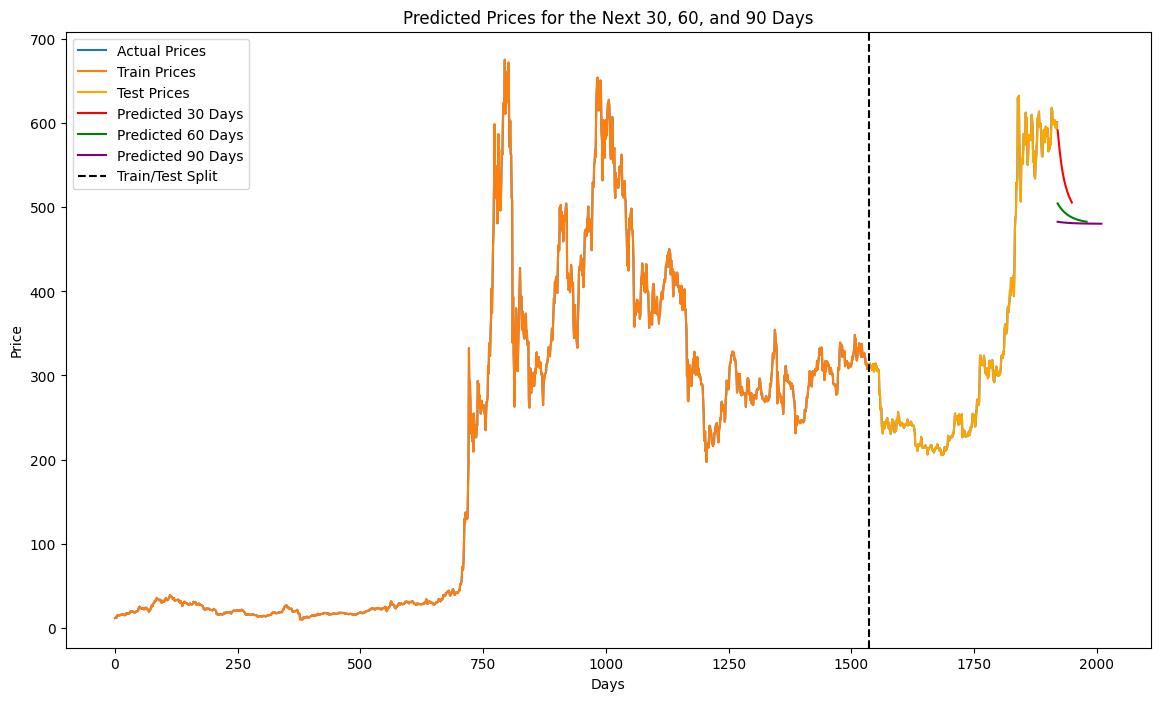

In [6]:
# Tính toán các ngày dự đoán
predict_days = [i for i in range(1, 91)]

# Vẽ biểu đồ gộp giá dự đoán 30, 60, và 90 ngày cùng với train và test
plt.figure(figsize=(14, 8))
plt.plot(range(len(prices)), prices, label='Actual Prices')
plt.plot(range(len(train)), scaler.inverse_transform(train), label='Train Prices')
plt.plot(range(len(train), len(train) + len(test)), scaler.inverse_transform(test), label='Test Prices', color='orange')
plt.plot(range(len(prices), len(prices) + 30), next_30_days_actual.flatten(), label='Predicted 30 Days', color='red')
plt.plot(range(len(prices), len(prices) + 60), next_60_days_actual.flatten(), label='Predicted 60 Days', color='green')
plt.plot(range(len(prices), len(prices) + 90), next_90_days_actual.flatten(), label='Predicted 90 Days', color='purple')
plt.axvline(x=len(train), color='black', linestyle='--', label='Train/Test Split')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Predicted Prices for the Next 30, 60, and 90 Days')
plt.legend()
plt.show()

#7:3

In [7]:
# Chỉ lấy cột giá đóng cửa
prices = data['Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Phân chia dữ liệu theo tỉ lệ 7:3
train_size = int(len(scaled_prices) * 0.7)
test_size = int(len(scaled_prices) * 0.3)

train, test = scaled_prices[0:train_size], scaled_prices[train_size:train_size+test_size]

print(f'train:{train_size}')
print(f'test:{test_size}')

# Hàm tạo các tập dữ liệu theo định dạng thích hợp cho mô hình GRU
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Định dạng lại dữ liệu đầu vào cho mô hình GRU [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


train:1344
test:576


In [8]:
# Xây dựng mô hình GRU
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(GRU(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)


Epoch 1/50
1283/1283 - 39s - loss: 0.0027 - 39s/epoch - 30ms/step
Epoch 2/50
1283/1283 - 34s - loss: 0.0011 - 34s/epoch - 26ms/step
Epoch 3/50
1283/1283 - 35s - loss: 9.3385e-04 - 35s/epoch - 27ms/step
Epoch 4/50
1283/1283 - 33s - loss: 8.4955e-04 - 33s/epoch - 26ms/step
Epoch 5/50
1283/1283 - 35s - loss: 8.9968e-04 - 35s/epoch - 27ms/step
Epoch 6/50
1283/1283 - 35s - loss: 7.8001e-04 - 35s/epoch - 27ms/step
Epoch 7/50
1283/1283 - 35s - loss: 7.4993e-04 - 35s/epoch - 27ms/step
Epoch 8/50
1283/1283 - 34s - loss: 8.0435e-04 - 34s/epoch - 26ms/step
Epoch 9/50
1283/1283 - 35s - loss: 7.3046e-04 - 35s/epoch - 28ms/step
Epoch 10/50
1283/1283 - 34s - loss: 7.7018e-04 - 34s/epoch - 26ms/step
Epoch 11/50
1283/1283 - 37s - loss: 7.2061e-04 - 37s/epoch - 29ms/step
Epoch 12/50
1283/1283 - 34s - loss: 8.1044e-04 - 34s/epoch - 27ms/step
Epoch 13/50
1283/1283 - 35s - loss: 6.8509e-04 - 35s/epoch - 27ms/step
Epoch 14/50
1283/1283 - 37s - loss: 6.7412e-04 - 37s/epoch - 28ms/step
Epoch 15/50
1283/1283 -

In [9]:
# Dự đoán trên tập test
test_predict = model.predict(X_test)

# Đảo ngược quá trình chuẩn hóa
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform([y_test])

# Tính toán các chỉ số đánh giá
mse = mean_squared_error(y_test_actual[0], test_predict[:,0])
mae = mean_absolute_error(y_test_actual[0], test_predict[:,0])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_actual[0] - test_predict[:,0]) / y_test_actual[0])) * 100

print("MAE: ",mae)
print("RMSE: ",rmse)
print("MAPE: ",mape)


17/17 [==============================] - 1s 14ms/step
MAE:  19.77081873480279
RMSE:  24.633127993855275
MAPE:  5.679304259382681


In [10]:
# Get the last 60 days of data for prediction
last_60_days = scaled_prices[-60:]

# Predict the next 30 days
next_30_days = []
for i in range(30):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_30_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Predict the next 60 days
next_60_days = []
for i in range(60):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_60_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Predict the next 90 days
next_90_days = []
for i in range(90):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_90_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Inverse transform the predicted values
next_30_days_actual = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1))
next_60_days_actual = scaler.inverse_transform(np.array(next_60_days).reshape(-1, 1))
next_90_days_actual = scaler.inverse_transform(np.array(next_90_days).reshape(-1, 1))

print("Predicted prices for the next 30 days:")
print(next_30_days_actual.flatten())

print("\nPredicted prices for the next 60 days:")
print(next_60_days_actual.flatten())

print("\nPredicted prices for the next 90 days:")
print(next_90_days_actual.flatten())

1/1 [==============================] - 0s 27ms/step
Predicted prices for the next 30 days:
[553.4223  525.2706  492.0373  451.46887 423.93805 403.36255 378.86044
 356.8908  340.60315 323.41507 305.2429  289.83545 275.89417 262.21198
 249.7218  238.2768  227.24504 216.81729 207.21384 198.31853 190.02943
 182.26839 175.01836 168.2447  161.95996 156.13359 150.7247  145.68878
 141.00304 136.65965]

Predicted prices for the next 60 days:
[132.63388  128.90686  125.44733  122.24194  119.26893  116.51797
 113.96923  111.61092  109.42496  107.4022   105.52821  103.79596
 102.19098  100.707924  99.33345   98.06454   96.88821   95.8034
  94.79689   93.869774  93.00845   92.21669   91.47959   90.80385
  90.172676  89.596504  89.05557   88.56494   88.100655  87.68373
  87.28436   86.93122   86.58648   86.28893   85.98969   85.74103
  85.47904   85.27402   85.04168   84.876495  84.66653   84.538826
  84.34395   84.25295   84.065506  84.01225   83.82371   83.81132
  83.61174   83.64604   83.42329   

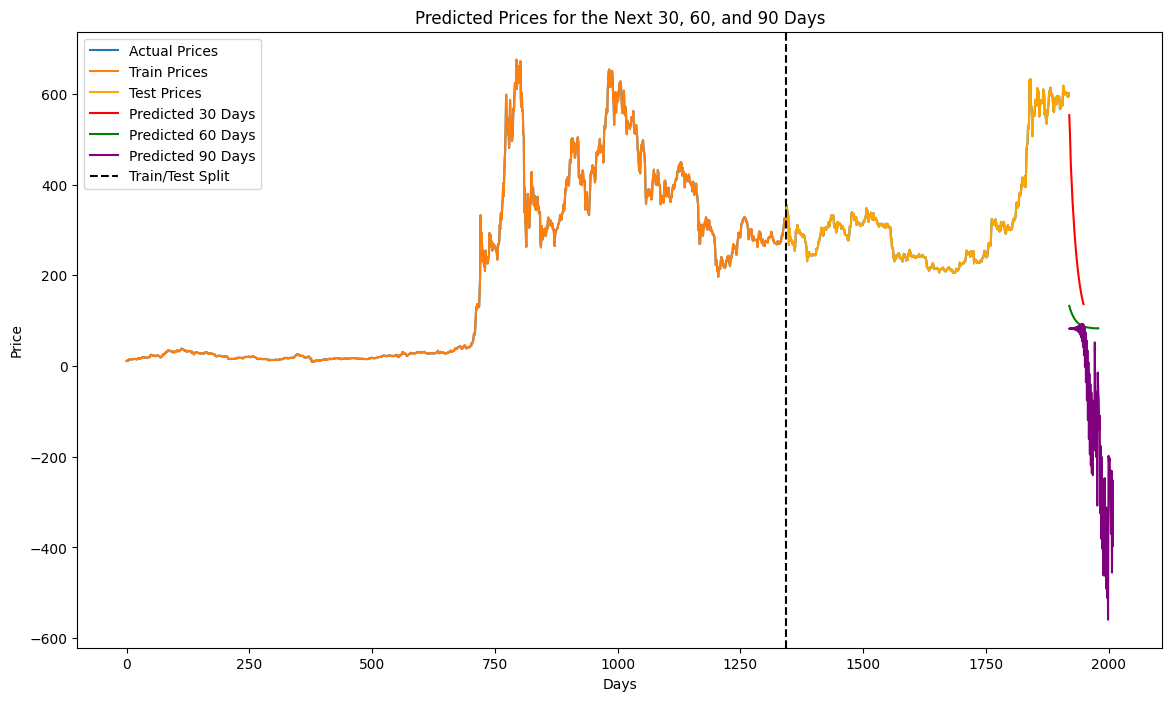

In [11]:
# Tính toán các ngày dự đoán
predict_days = [i for i in range(1, 91)]

# Vẽ biểu đồ gộp giá dự đoán 30, 60, và 90 ngày cùng với train và test
plt.figure(figsize=(14, 8))
plt.plot(range(len(prices)), prices, label='Actual Prices')
plt.plot(range(len(train)), scaler.inverse_transform(train), label='Train Prices')
plt.plot(range(len(train), len(train) + len(test)), scaler.inverse_transform(test), label='Test Prices', color='orange')
plt.plot(range(len(prices), len(prices) + 30), next_30_days_actual.flatten(), label='Predicted 30 Days', color='red')
plt.plot(range(len(prices), len(prices) + 60), next_60_days_actual.flatten(), label='Predicted 60 Days', color='green')
plt.plot(range(len(prices), len(prices) + 90), next_90_days_actual.flatten(), label='Predicted 90 Days', color='purple')
plt.axvline(x=len(train), color='black', linestyle='--', label='Train/Test Split')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Predicted Prices for the Next 30, 60, and 90 Days')
plt.legend()
plt.show()

#6:4

In [12]:
# Chỉ lấy cột giá đóng cửa
prices = data['Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Phân chia dữ liệu theo tỉ lệ 6:2:2
train_size = int(len(scaled_prices) * 0.6)
test_size = int(len(scaled_prices) * 0.4)

train, test = scaled_prices[0:train_size], scaled_prices[train_size:train_size+test_size]

# Hàm tạo các tập dữ liệu theo định dạng thích hợp cho mô hình GRU
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Định dạng lại dữ liệu đầu vào cho mô hình GRU [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [13]:
# Xây dựng mô hình GRU
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(GRU(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)


Epoch 1/50
1091/1091 - 33s - loss: 0.0020 - 33s/epoch - 30ms/step
Epoch 2/50
1091/1091 - 29s - loss: 0.0011 - 29s/epoch - 27ms/step
Epoch 3/50
1091/1091 - 29s - loss: 9.5113e-04 - 29s/epoch - 27ms/step
Epoch 4/50
1091/1091 - 30s - loss: 0.0011 - 30s/epoch - 28ms/step
Epoch 5/50
1091/1091 - 31s - loss: 9.7992e-04 - 31s/epoch - 28ms/step
Epoch 6/50
1091/1091 - 29s - loss: 8.9661e-04 - 29s/epoch - 27ms/step
Epoch 7/50
1091/1091 - 29s - loss: 8.1689e-04 - 29s/epoch - 27ms/step
Epoch 8/50
1091/1091 - 29s - loss: 8.4288e-04 - 29s/epoch - 27ms/step
Epoch 9/50
1091/1091 - 31s - loss: 8.5908e-04 - 31s/epoch - 28ms/step
Epoch 10/50
1091/1091 - 31s - loss: 7.7997e-04 - 31s/epoch - 29ms/step
Epoch 11/50
1091/1091 - 33s - loss: 8.5819e-04 - 33s/epoch - 30ms/step
Epoch 12/50
1091/1091 - 30s - loss: 7.0235e-04 - 30s/epoch - 28ms/step
Epoch 13/50
1091/1091 - 30s - loss: 7.3910e-04 - 30s/epoch - 27ms/step
Epoch 14/50
1091/1091 - 31s - loss: 7.5875e-04 - 31s/epoch - 28ms/step
Epoch 15/50
1091/1091 - 30s

In [14]:
# Dự đoán trên tập test
test_predict = model.predict(X_test)

# Đảo ngược quá trình chuẩn hóa
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform([y_test])

# Tính toán các chỉ số đánh giá
mse = mean_squared_error(y_test_actual[0], test_predict[:,0])
mae = mean_absolute_error(y_test_actual[0], test_predict[:,0])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_actual[0] - test_predict[:,0]) / y_test_actual[0])) * 100

print("MAE: ",mae)
print("RMSE: ",rmse)
print("MAPE: ",mape)


23/23 [==============================] - 1s 15ms/step
MAE:  8.040564033424959
RMSE:  11.627188316188896
MAPE:  2.5214018711139667


In [15]:
# Get the last 60 days of data for prediction
last_60_days = scaled_prices[-60:]

# Predict the next 30 days
next_30_days = []
for i in range(30):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_30_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Predict the next 60 days
next_60_days = []
for i in range(60):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_60_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Predict the next 90 days
next_90_days = []
for i in range(90):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_90_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Inverse transform the predicted values
next_30_days_actual = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1))
next_60_days_actual = scaler.inverse_transform(np.array(next_60_days).reshape(-1, 1))
next_90_days_actual = scaler.inverse_transform(np.array(next_90_days).reshape(-1, 1))

print("Predicted prices for the next 30 days:")
print(next_30_days_actual.flatten())

print("\nPredicted prices for the next 60 days:")
print(next_60_days_actual.flatten())

print("\nPredicted prices for the next 90 days:")
print(next_90_days_actual.flatten())

1/1 [==============================] - 0s 28ms/step
Predicted prices for the next 30 days:
[586.64276 575.13947 564.99133 554.3824  544.088   535.8441  526.9497
 518.94446 512.04834 505.4377  499.48392 494.42307 489.81482 485.73694
 482.23502 479.11652 476.33835 473.90356 471.72733 469.7698  468.02518
 466.46045 465.0505  463.78787 462.65594 461.63846 460.72662 459.90945
 459.17578 458.5178 ]

Predicted prices for the next 60 days:
[457.92715 457.39673 456.9202  456.4919  456.10684 455.76028 455.4486
 455.168   454.91504 454.68726 454.48178 454.2965  454.12918 453.97824
 453.84174 453.7183  453.6067  453.50574 453.4143  453.33148 453.25647
 453.18842 453.1266  453.0704  453.01932 452.97302 452.93085 452.8924
 452.8574  452.82544 452.79633 452.7696  452.74536 452.72324 452.70288
 452.68433 452.6672  452.65152 452.63724 452.62418 452.61197 452.60086
 452.5906  452.58115 452.57254 452.5645  452.5571  452.55026 452.54395
 452.53812 452.53275 452.52786 452.5233  452.5191  452.51535 452.5118

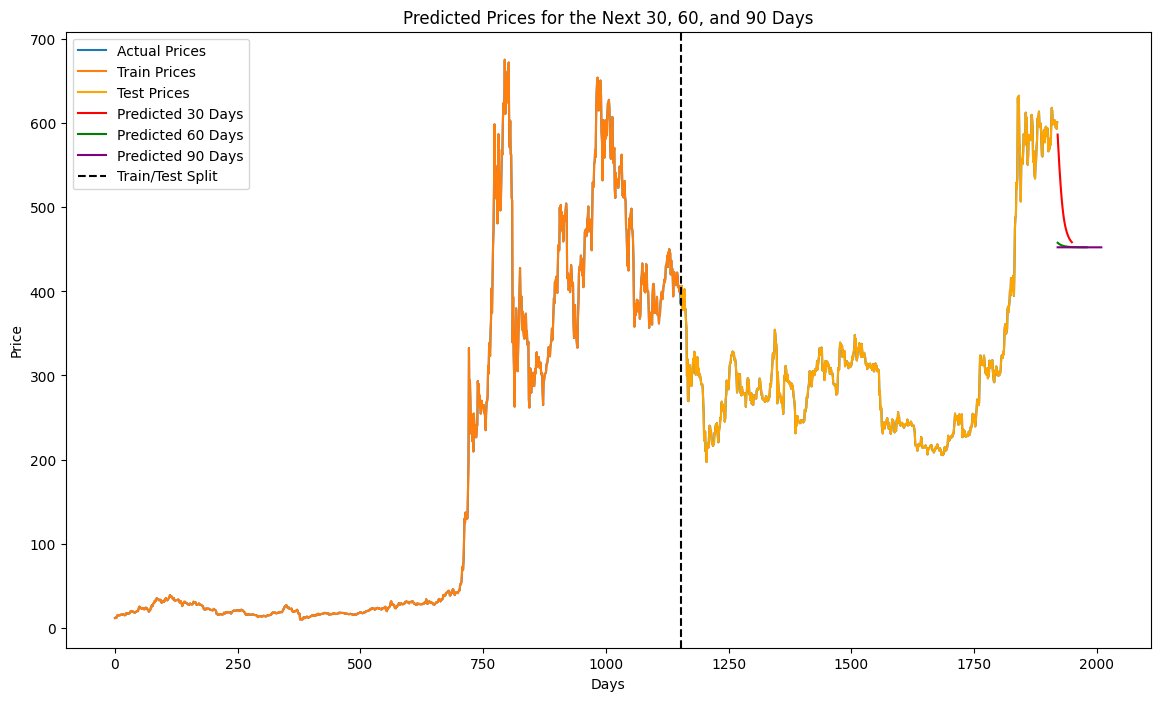

In [16]:
# Tính toán các ngày dự đoán
predict_days = [i for i in range(1, 91)]

# Vẽ biểu đồ gộp giá dự đoán 30, 60, và 90 ngày cùng với train và test
plt.figure(figsize=(14, 8))
plt.plot(range(len(prices)), prices, label='Actual Prices')
plt.plot(range(len(train)), scaler.inverse_transform(train), label='Train Prices')
plt.plot(range(len(train), len(train) + len(test)), scaler.inverse_transform(test), label='Test Prices', color='orange')
plt.plot(range(len(prices), len(prices) + 30), next_30_days_actual.flatten(), label='Predicted 30 Days', color='red')
plt.plot(range(len(prices), len(prices) + 60), next_60_days_actual.flatten(), label='Predicted 60 Days', color='green')
plt.plot(range(len(prices), len(prices) + 90), next_90_days_actual.flatten(), label='Predicted 90 Days', color='purple')
plt.axvline(x=len(train), color='black', linestyle='--', label='Train/Test Split')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Predicted Prices for the Next 30, 60, and 90 Days')
plt.legend()
plt.show()